# NVIDIA Nsight Systems
[NVIDIA Nsight™ Systems](https://developer.nvidia.com/nsight-systems) is a system-wide performance analysis tool designed to visualize an application’s algorithms, help to identify the largest opportunities to optimize, and tune to scale efficiently across any quantity or size of CPUs and GPUs.

# NVIDIA Tools Extension (NVTX)
The [NVIDIA® Tools Extension Library (NVTX)](https://github.com/NVIDIA/NVTX) is a powerful mechanism that allows users to manually instrument their application. With a C-based and a python-based Application Programming Interface (API) for annotating events, code ranges, and resources in your applications. Applications which integrate NVTX can use NVIDIA Nsight, Tegra System Profiler, and Visual Profiler to capture and visualize these events and ranges. In general, the NVTX can bring valuable insight into the application while incurring almost no overhead.

# MONAI Training Pipeline and NVTX
[MONAI](https://github.com/Project-MONAI/MONAI) is a high level framework for deep learning in healthcare imaging. 

For performance profiling, we mainly focus on two fronts: data loading/transforms, and training/validation iterations.

[Transforms](https://github.com/Project-MONAI/MONAI/tree/dev/monai/transforms) is one core concept of data handling in MONAI, similar to [TorchVision Transforms](https://pytorch.org/vision/stable/transforms.html). Several of these transforms are usually chained together, using a [Compose](https://github.com/Project-MONAI/MONAI/blob/2f1c7a5d1b47c8dd21681dbe1b67213aa3278cd7/monai/transforms/compose.py#L35) class, to create a preprocessing or postprocessing pipeline that performs manipulation of the input data and make it suitable for training a deep learning model or inference. To dig into the cost from each individual transform, we enable the insertion of NVTX annotations via [MONAI NVTX Transforms](https://github.com/Project-MONAI/MONAI/blob/dev/monai/utils/nvtx.py).

For training and validation steps, they are easier to track by setting NVTX annotations within the loop.

# Profiling Spleen Segmentation Pipeline
## Environment Setup
Install packages and download dataset.

In [ ]:
!pip install git+https://github.com/Project-MONAI/MONAI
!pip install pytorch-ignite
!pip install nibabel
!pip install tqdm
!pip install -q "nvidia-pyindex"
!pip install -q "nvidia-dlprof[pytorch]"
!pip install -q "nvtx"

## Run Nsight Profiling 
We run DLprof (v1.4.0 / r21.08) on the trainer under basic settings for 6 epochs (with validation every 2 epochs). All results shown below are from experiments performed on a DGX-2 workstation using a single V-100 GPU.

In [ ]:
!dlprof --mode pytorch \
        --reports=summary \
        --formats json \
        --output_path ./outputs_base \
        python3 train_base_nvtx.py 

# Identify Potential Performance Improvements 
## Profile Results
After profiling, DLProf provides summary regarding the training process. Also, the computing details can be visualized via Nsight System GUI. (The version of Nsight used in the tutorial is 2021.3.1.54-ee9c30a OSX)

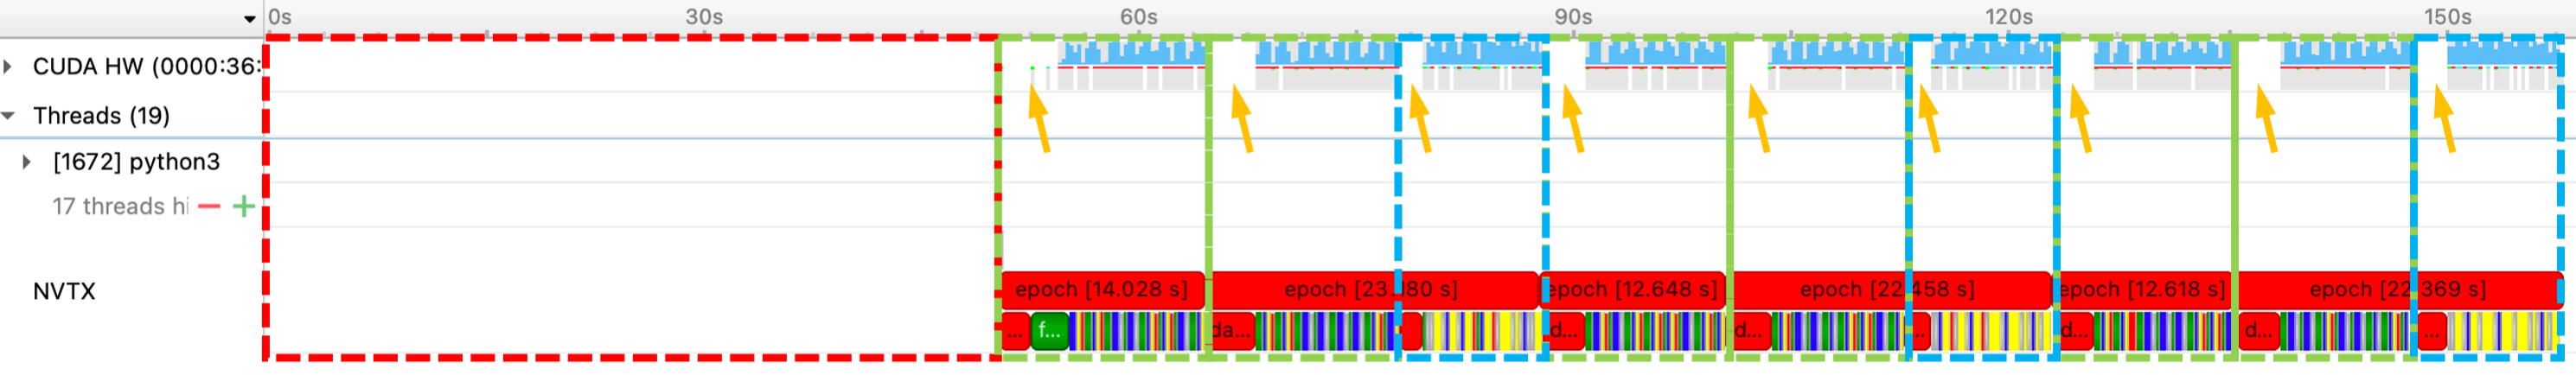

In [3]:
from IPython.display import display, Image
display(Image(filename="Figure/nsight_base.png", width=1200))

## Observations
As shown in the above figure, we focus on two sections: CUDA (first row), and NVTX (last two rows). Nsight provides information regarding GPU utilization (CUDA), and specific NVTX tags we added to track certain behaviors.
In this example, we added NVTX tags to track each epoch, as well as operations within each step (data transforms, forward, backward, etc.). As shown within the second last row, each solid red block represents a single epoch.
As we perform validation every two epochs, the even epochs will be longer than odd ones since it includes both training (green dashed region) and validation (blue dashed region).
Also in this pipeline, we used CacheDataset, and the initial 40~50 seconds (red dashed region) are for loading all training images into CPU RAM.

As can be observed from the figure, we can notice that there are data loading/IO gaps between epochs (pointed by orange arrows).

Let's zoom-in and look closer at the beginning of the second epoch.

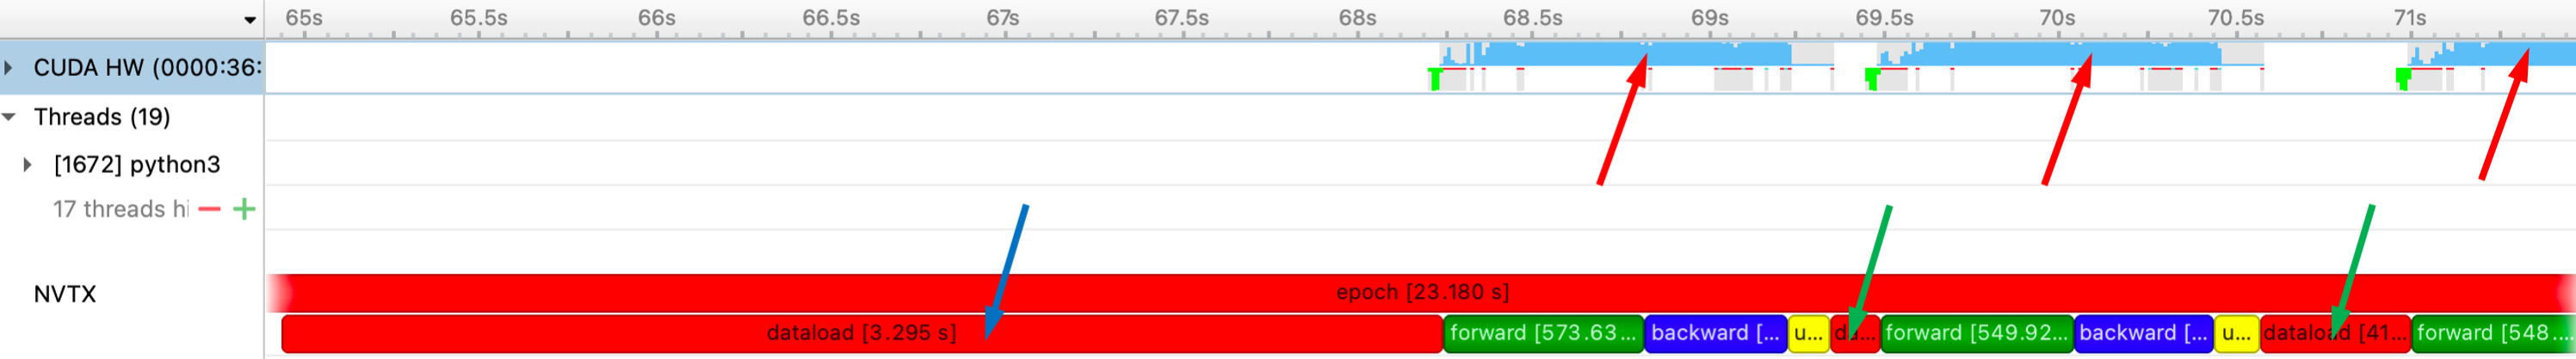

In [5]:
display(Image(filename="Figure/nsight_base_zoom.png", width=1200))

As shown in the zoomed view:
- Between epochs, there are considerable amount of time cost for data loading (pointed by the blue arrow);
- Between steps of training, the time of data loading is much smaller (pointed by green arrows);
- The GPU utilization (CUDA HW) is decent during training step (pointed by red arrows);

Upon further analysis of convergence, it appears that the convergence is relatively slow (blue curve in the tensorboard figure below). Therefore, there are two directions of performance improvement:

- Per-epoch time reduction: by utilizing pre-indexing and thread-based dataloader for more efficient dataloading;
- Faster convergence: by utilizing different optimizers and loss functions.

One optimized solution can be found here (https://github.com/Project-MONAI/tutorials/blob/master/acceleration/fast_training_tutorial.ipynb). Based on the validation accuracy curves, we can observe that the optimized solution (<font color='orange'>orange curve</font>) has much faster convergence. The GPU utilization rate is above 90% on average.

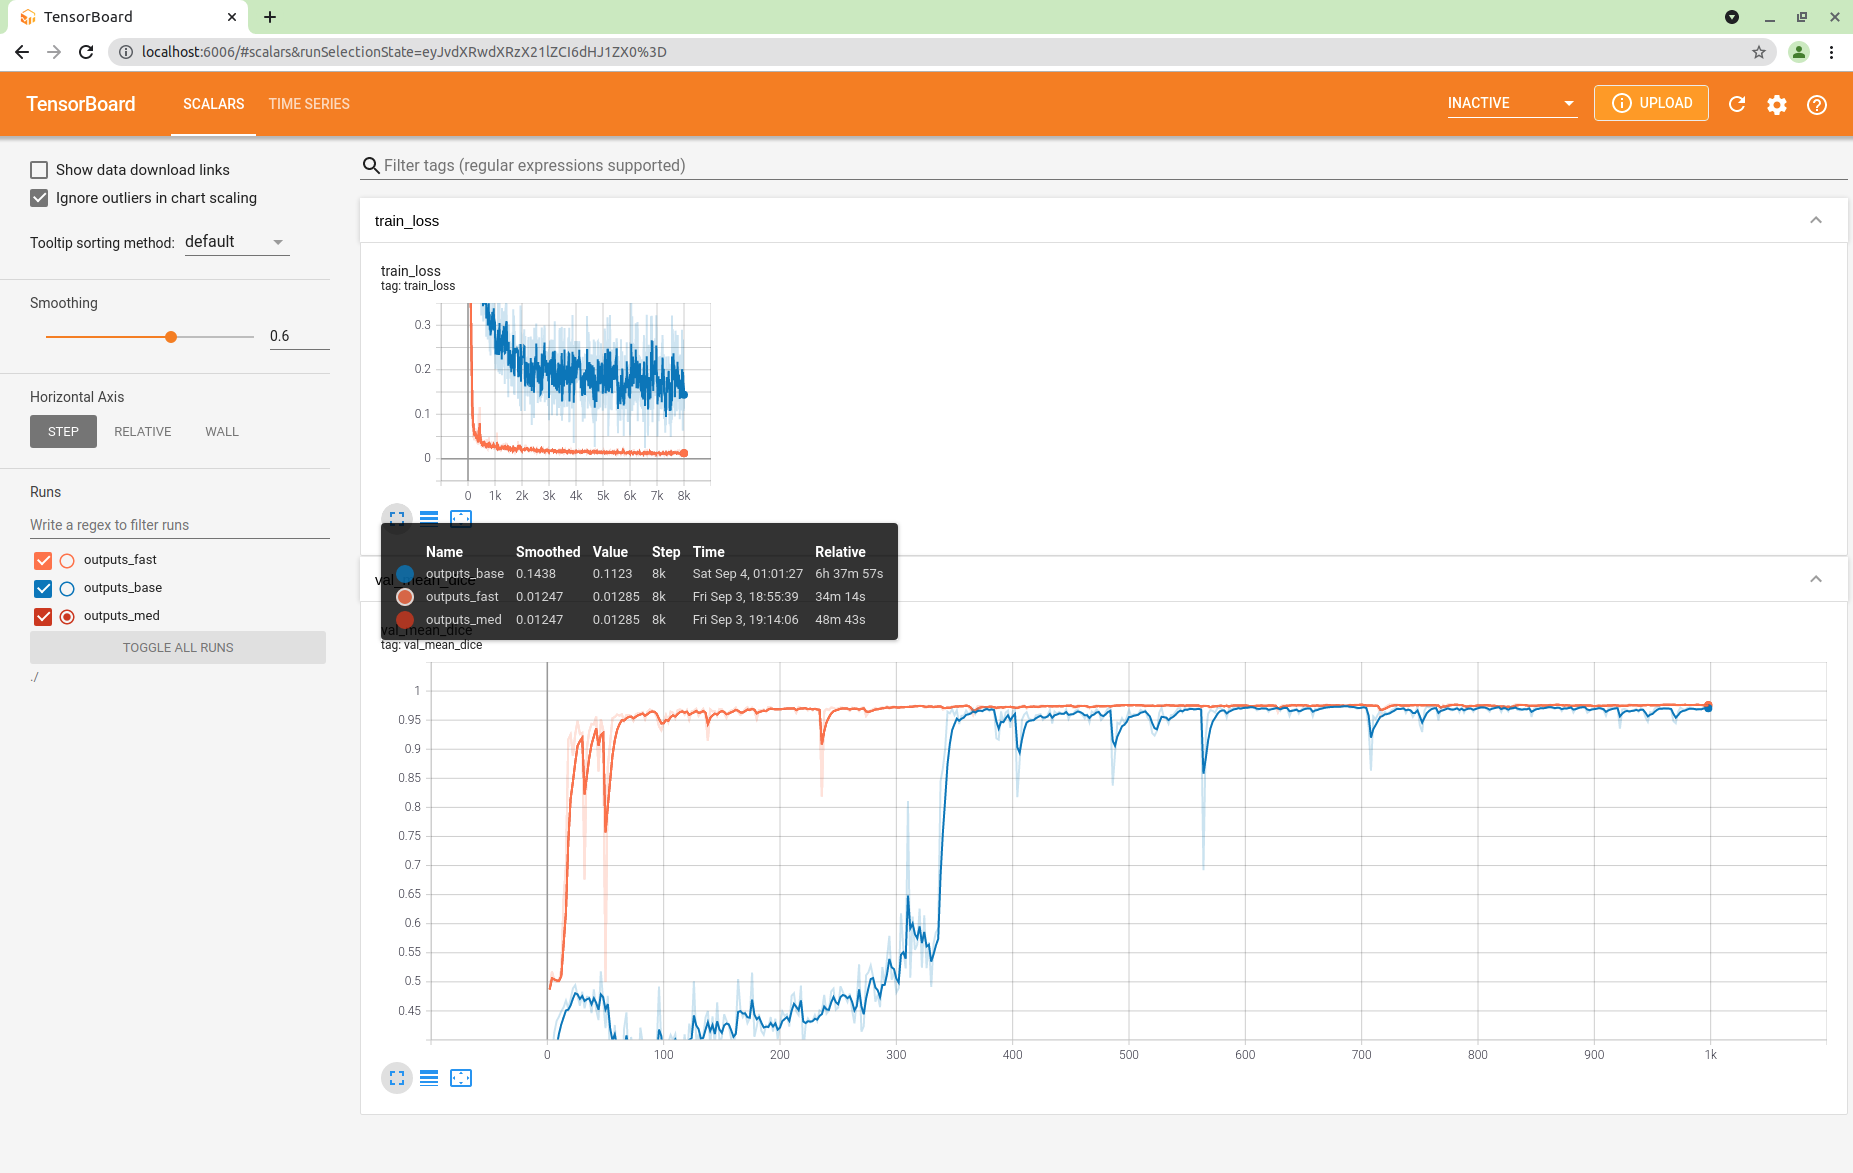

In [4]:
display(Image(filename="Figure/tensorboard.png", width=800))

# Analyzing Performance Improvement
## Profile Results
We again use DLProf to further analyze the optimized training script.

In [ ]:
!dlprof --mode pytorch \
        --reports=summary \
        --formats json \
        --output_path ./outputs_fast \
        python3 train_fast_nvtx.py 

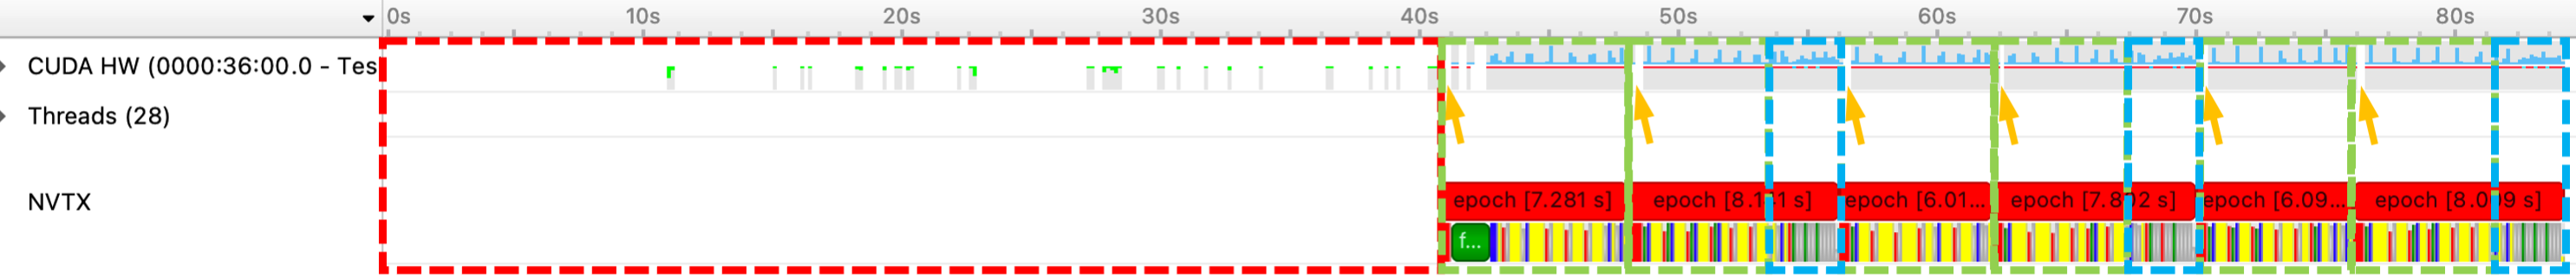

In [7]:
display(Image(filename="Figure/nsight_fast.png", width=1200))

As shown in the figure, the optimized solution:
- Still has the initial 40~50 seconds (<font color='red'>red dashed region</font>) for loading all training images into CPU RAM; 
- Uses much less time for data loading (pointed by <font color='orange'>orange arrows</font>);
- The total time per epoch on training (<font color='green'>green dashed region</font>) and validation (<font color='blue'>blue dashed region</font>) has been significantly reduced. For the baseline pipeline, a traning epoch takes 12-14 sec, and a training+validation epoch takes 22-23 sec; for the improved pipeline, a training epoch takes 6-7 sec, and a training+validation epoch takes ~8 sec.  

Therefore, the computing efficiency and the overall training process are thus be improved by a large margin.

Moreover, another profiling example for pathological image analysis can be found in the following [link](https://github.com/Project-MONAI/tutorials/blob/master/performance_profiling/pathology/profiling_train_base_nvtx.ipynb).